In [1]:
import numpy as np
# import cv2
import pandas as pd
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Preprocessing

## Create fake filepaths dataframe

In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
original_fake_paths = []

for dirname, _, filenames in tqdm(os.walk('test/')):
    for filename in filenames:
        original_fake_paths.append([os.path.join(dirname, filename), filename])

0it [00:00, ?it/s]

## First downsize all the images

In [5]:
save_dir = 'tmp/fake/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [6]:
fake_paths = [save_dir + filename for _, filename in original_fake_paths]

In [15]:
for path, filename in tqdm(original_fake_paths):
    try:
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))
        cv2.imwrite(os.path.join(save_dir, filename), img)
    except Exception as e:
        print(str(e))

  0%|          | 0/160001 [00:00<?, ?it/s]

OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-i1s8y2i1\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [7]:
train_fake_paths, test_fake_paths = train_test_split(fake_paths, test_size=0.1, random_state=2023)

fake_train_df = pd.DataFrame(train_fake_paths, columns=['filename'])
fake_train_df['class'] = 'FAKE'

fake_test_df = pd.DataFrame(test_fake_paths, columns=['filename'])
fake_test_df['class'] = 'FAKE'

## Create real file paths dataframe

In [9]:
real_dir = 'input/celeba-dataset/img_align_celeba/img_align_celeba/'
eval_partition = pd.read_csv('kaggle/input/celeba/list_eval_partition.csv')

eval_partition['filename'] = eval_partition.image_id.apply(lambda st: real_dir + st)
eval_partition['class'] = 'REAL'

In [10]:
real_train_df = eval_partition.query('partition in [0, 1]')[['filename', 'class']]
real_test_df = eval_partition.query('partition == 2')[['filename', 'class']]

## Combine both real and fake for dataframe

In [20]:
train_df = pd.concat([real_train_df, fake_train_df])
test_df = pd.concat([real_test_df, fake_test_df])

# Generator

In [21]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    train_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_dataframe(
    train_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

D:\Anaconda\ProgramFile\envs\newVAD\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 261309 validated image filenames belonging to 2 classes.


D:\Anaconda\ProgramFile\envs\newVAD\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 65327 validated image filenames belonging to 2 classes.


In [22]:
datagen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 35963 validated image filenames belonging to 2 classes.


# Modelling

## Load and freeze DenseNet

In [23]:
densenet = DenseNet121(
    include_top=False,
    input_shape=(224,224,3)
)

for layer in densenet.layers:
    layer.trainable = False

29089792/29084464 [==============================] - 3s 0us/step


## Build Model

In [24]:
def build_model(densenet):
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0005),
        metrics=['accuracy']
    )
    
    return model

In [25]:
model = build_model(densenet)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

## Training Phase 1 - Only train top layers

In [28]:
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

train_history_step1 = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[checkpoint],
    epochs=7
)

Epoch 1/7
4083/4083 [==============================] - 14381s 4s/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 2.1090e-04 - val_accuracy: 0.9999
Epoch 2/7
4083/4083 [==============================] - 11883s 3s/step - loss: 0.0047 - accuracy: 0.9983 - val_loss: 2.6350e-04 - val_accuracy: 0.9999
Epoch 3/7
4083/4083 [==============================] - 10978s 3s/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 1.9786e-04 - val_accuracy: 0.9999
Epoch 4/7
4083/4083 [==============================] - 11144s 3s/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 1.0239e-04 - val_accuracy: 1.0000
Epoch 5/7
4083/4083 [==============================] - 11310s 3s/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 7.6755e-05 - val_accuracy: 1.0000
Epoch 6/7
4083/4083 [==============================] - 14159s 3s/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 1.4765e-04 - val_accuracy: 1.0000
Epoch 7/7
4083/4083 [==============================] - 13316s 3s/step - loss: 0.0030 - accuracy: 0.9

## Training Phase 2 - Unfreeze and train all

In [29]:
model.load_weights('model.h5')
for layer in model.layers:
    layer.trainable = True

train_history_step2 = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[checkpoint],
    epochs=3
)

Epoch 1/3
4083/4083 [==============================] - 15160s 4s/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 1.5904e-04 - val_accuracy: 0.9999
Epoch 2/3
4083/4083 [==============================] - 12765s 3s/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 1.4561e-04 - val_accuracy: 1.0000
Epoch 3/3
4083/4083 [==============================] - 12547s 3s/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 5.0393e-05 - val_accuracy: 1.0000


## Eval

In [30]:
pd.DataFrame(train_history_step1.history).to_csv('history1.csv')
pd.DataFrame(train_history_step2.history).to_csv('history2.csv')

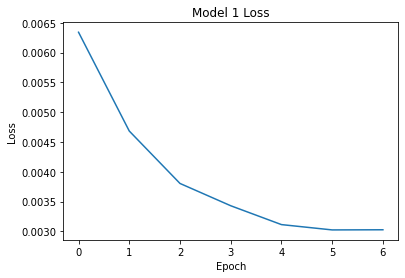

In [32]:
import matplotlib.pyplot as plt
plt.plot(train_history_step1.history['loss'])
plt.title('Transfer Learning DenseNet-121 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

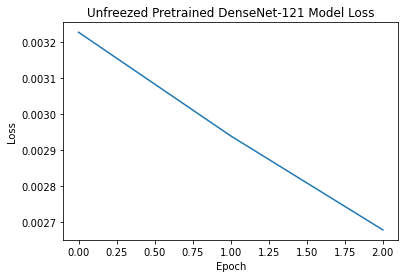

In [34]:
plt.plot(train_history_step2.history['loss'])
plt.title('Unfreezed Pretrained DenseNet-121 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## It is evident from the Training process and the validation scores that this methodology supersedes the proposed method